## Model Selection and parameter optimization

For this problem, there are three main sources of hyper-parameters (e.g. parameters not optimized during the training):  
- Vectorizer parameters for tokenizing strategy (n-grams range, min. document frecuency, etc)  
- Specific parameters from each learning algorithm (Bayes: smoothing alpha, SVM: kernel type (linear,gauss), etc)  
- Regularization parameters (C (for SMV and Logit), penalty type (l1,l2) ).

The best performing model will be obtained as an specific combination of values in the hyper-parameters space. Such combination can be obtained by means of **cross-validation**. In scikit-learn we can search on a defined grid of hyperparameters for the best model. The `GridSearchCV`,`Pipeline`, and `FeatureUnion` classes can be used in combination to cross-validate along our data pipeline.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
df = pd.read_csv('spam.csv')
df['target'] = np.where(df['target']=='spam',1,0)
df['msg_len']  = df['text'].str.len()
df['non_word_char'] = df["text"].str.count(r'\W')
df['num_char'] = df["text"].str.count(r'\d')
X_train, X_test, y_train, y_test = train_test_split(df[['text','msg_len','non_word_char','num_char']],
                                                    df['target'], random_state=0,train_size=0.85)

from scipy.sparse import csr_matrix, hstack
add_sparse_feat = lambda X_sparse_set, new_feat: hstack( [X_sparse_set, csr_matrix(new_feat).T], 'csr')

In [3]:
def plot_cross_validation_results(parameters,grid_search):
    n = len(parameters)
    fig, _ = plt.subplots(n-1,n-1,figsize=(1.85*n,1.85*n),sharex='col',sharey='row')
    plt.tight_layout()
    plt.subplots_adjust(left=.05,right=.97,top=0.98,bottom=0.11,wspace=0.04,hspace=0.04)
    
    hyper_param = [i.split("__")[1] for i in parameters.keys()]    
    cv_res = pd.DataFrame(grid_search.cv_results_)
    name_formater = lambda i: 'param_'+ list(parameters.keys())[i]
    
    for i in range(n):
        for j in range(n):
            if j>=i: continue
            cv_pvt = pd.pivot_table(cv_res, values='mean_test_score',index= name_formater(i), columns=name_formater(j))
            z = (i-1)*(n-1) + (j+1)
            ax = plt.subplot(n-1,n-1,z)
            sns.heatmap(cv_pvt,annot=True,cbar=False,vmin=0.8,vmax=1.0,cmap="cividis",linewidths=.005)

            if i<n-1: ax.get_xaxis().set_visible(False)
            else: ax.set_xlabel(hyper_param[j])
            
            if j>0: ax.get_yaxis().set_visible(False)
            else: ax.set_ylabel(hyper_param[i])
 
    return

## Cross validation for LogisticRegression

/home/cesarliz10/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<IPython.core.display.Javascript object>


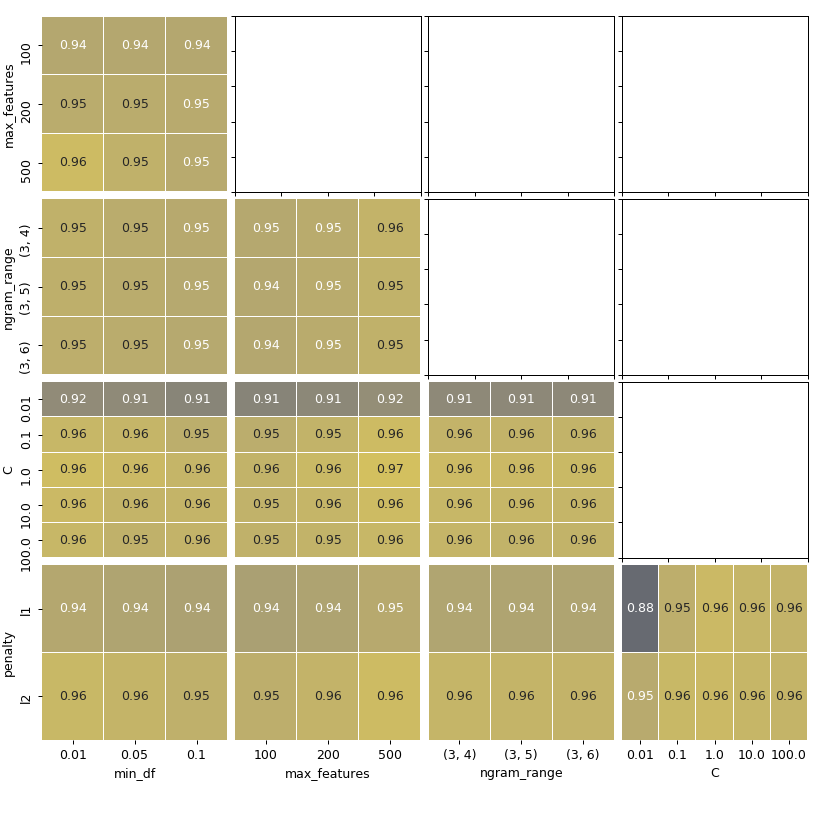

In [4]:
pipeline = Pipeline([
        ('vectorizer',CountVectorizer(analyzer='char_wb')),
        ('clf',LogisticRegression())
    ])
parameters = {
    'vectorizer__min_df': (0.01,0.05,0.1),
    'vectorizer__max_features' : (100,200,500),
    'vectorizer__ngram_range' : ((3,4),(3,5),(3,6)),
    'clf__C' : (1e-2,1e-1,1,10,1e2),
    'clf__penalty': ('l1','l2')
}
grid_search = GridSearchCV(pipeline,parameters, cv=5, n_jobs=-1,verbose=0)
grid_search.fit(X_train["text"],y_train)
plot_cross_validation_results(parameters,grid_search)

## Cross validation for Multinomial NaiveBayes

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   37.8s finished


<IPython.core.display.Javascript object>


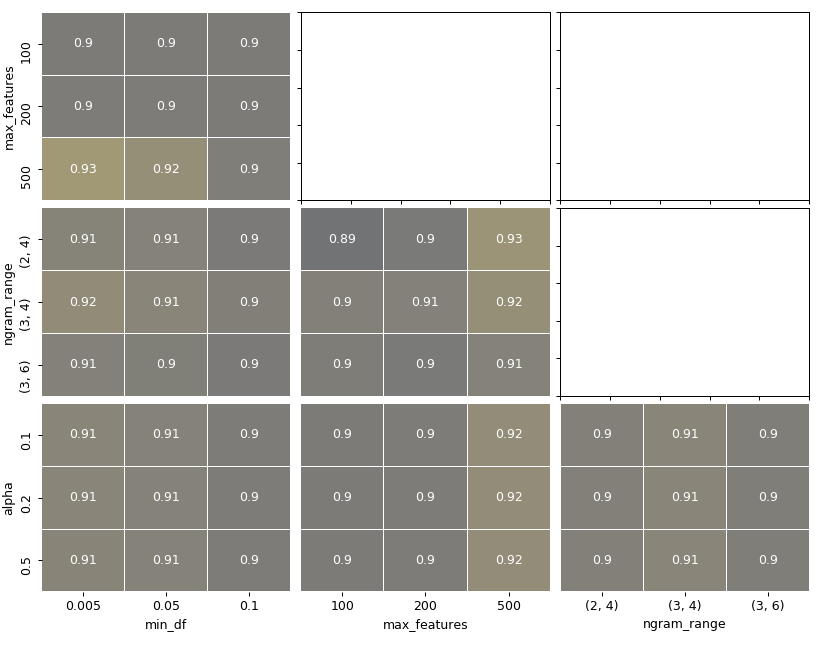

In [9]:
pipeline = Pipeline([
        ('vectorizer',CountVectorizer(analyzer='char_wb')),
        ('clf',MultinomialNB())
    ])
parameters = {
    'vectorizer__min_df': (0.005,0.05,0.1),
    'vectorizer__max_features' : (100,200,500),
    'vectorizer__ngram_range' : ((2,4),(3,4),(3,6)),
    'clf__alpha' : (0.1,0.2,0.5)
}
grid_search_nb = GridSearchCV(pipeline,parameters, cv=3, n_jobs=-1,verbose=1)
grid_search_nb.fit(X_train["text"],y_train)
plot_cross_validation_results(parameters,grid_search_nb)

## Cross validation for Multinomial NaiveBayes